MJ Rose with scripts from J. Callingham


You can either run this notebook directly, 
or run it through the [master notebook](analysis_batchrun.ipynb) for batch processing.

If you have run this automatically and now want to customize the analysis, make sure to save this under a different name or it might be overwritten by the batch processing script

# Imports, functions

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import Image, display
from IPython.display import HTML as html_print
import numpy as np
import os, glob, subprocess, time, psutil, sys, shutil, fnmatch
import pandas as pd
import pymultinest,os, threading, subprocess, time, math
import scipy.optimize as opt
import scipy.stats as stats
import scipy.special as special # For access to the incomplete gamma function.
import emcee, corner
from collections import namedtuple
from collections import OrderedDict
import copy


if not os.path.exists("chains"): os.mkdir("chains") # This is important.
# This makes a directory called "chains". This is where the walker information
# is being stored by Multinest. All Pymultinest does is then read them in.

# in case you start script from child directory
try:
    # Joe's SED plotting 
    import seds_plot_func
    from gpscssmodels import *

    # my own
    from reduction_funcs import *
except:
    sys.path.insert(0,'..')
    import seds_plot_func
    from gpscssmodels import *
    from reduction_funcs import *

# for nbrun 
array = np.array

# by default, sets up and does analysis form pks1740-649
    

# set save path
image_dir = "/Users/mmcintosh/Dropbox/ASTRON2017/C3030/model_plots/"
if not os.path.exists(image_dir):
	os.makedirs(image_dir)
 
# set save path
model_ev_dir = "/Users/mmcintosh/Dropbox/ASTRON2017/C3030/model_ev/"
if not os.path.exists(model_ev_dir):
	os.makedirs(model_ev_dir)
    
if not os.path.exists(model_ev_dir+'modeled_df.pkl'):
    # read in data
    sedfile = 'sed_df.pkl'
    sed_loc = os.getcwd()+"/"+sedfile
    sed_df = pd.read_pickle(sed_loc)
    sed_df.to_pickle(model_ev_dir+'modeled_df.pkl')
    
# read in data
sed_df = pd.read_pickle(model_ev_dir+'modeled_df.pkl')
    
    
# # default source to model
interactive = False
source_index = 90
nwalkers = 50 
nsteps = 1000 
burnin = 500

In [2]:
# custom function 

def print_color(s, color='black'):
     display(html_print("<text style=color:{}>{}</text>".format(color, s)))
        
        
def get_argnames(func):
    return(func.__code__.co_varnames[:func.__code__.co_argcount][1:])


def help_unpack(theta):
    if isinstance(theta,np.ndarray):
        return(copy.copy(theta))
    else:
        # its probably a generator func from multinest
        temp = [theta[i] for i in np.arange(ndim)]
        return(temp)

def init_repeated_params(arg, param):
    ''' if you have something like Snorm, Snorm2, Snorm3
    then this function places them at 2x, 4x, 6x ... out 
    from the original Snorm '''
    temp = re.search('\d', arg)
    if temp is not None:
        occurance = int(temp.group())
        if occurance >= 2:
            param = param *2*(occurance -1)
    return(param)

Prior = namedtuple('Prior', ['guess', 'min', 'max'])
def make_prior_dictionary(func, x,y):
    argnames = get_argnames(func)
    # set up prior information
    keys = []
    for arg in argnames:
        if "norm" in arg:
            param = Prior(init_repeated_params(arg, np.max(y)), 0.0, 100.*np.max(y))
        elif "alpha" in arg:
            param = Prior(0.7, 0.0, 10.0)
        elif "freq" in arg:
            param = Prior(init_repeated_params(arg, x[np.argmax(y)]), 0.0, 20e+3)
        elif "p" in arg:
            param = Prior(-0.3, -10.0, 10.0)
        elif "beta" in arg:
            param = Prior(3, 1.0, 10.0)
        elif "gamma" in arg:
            param = Prior(1., 0.0, 10.0)
        elif 'q' in arg:
            param = Prior(1., 0.0, 10.0)
        else:
            param = Prior(1., 0.0, 20e+3)
        keys.append(param)
    dictionary = OrderedDict(zip(argnames, keys))
    return(dictionary)

def check_if_in_prior(theta, prior_dict, set_to_nearest=False, set_to_random=False): 
    ''' if parameters are within the prior boundaries, returns them. Otherwise, it returns False.
    set_to_nearest replaces the out of bounds value with the nearest boundary'''
    params = help_unpack(theta)
    for i, (name, prior) in enumerate(prior_dict.items()): 
        if not (prior.min <= params[i] < prior.max):
            #if set_to_nearest: 
                # if not within prior bounds, set the param equal to the closest boundary
                #params[i] = min([prior.min, prior.max], key=lambda x:abs(x-params[i]))
            if set_to_random:
                # if not within prior bounds, set it to a random value in between max & min
                params[i] = np.random.uniform(prior.min,prior.max,1)[0]
            else:
                return(False)
    return(np.array(params))

# for both emcee and multinest
def lnlike(theta, ndim, nparams):
    #(theta,x,y,yerr,func):
    params = help_unpack(theta)
    inv_sigma = 1.0/(yerr**2)
    loglike = -0.5*(np.nansum((y-func(x,*params))**2*inv_sigma - np.log(inv_sigma))) 
    
    # the model will return -0.0 if it gets a divide by zero error, 
    # which happens if the parameters are too big
    if loglike == -0.0:
        loglike = -np.inf
    return(loglike)

def emcee_lnprior(theta, prior_dict): 
    params = check_if_in_prior(theta, prior_dict)
    if not isinstance(params, np.ndarray):
        return(-np.inf)
    else:
        # flat prior
        return(0.00)
   
def multinest_lnprior(cube, ndim, n_params):
    '''This transforms a unit cube into the dimensions of your prior
    space to search. Make sure you do this right!'''
    for i in np.arange(ndim):
        cube[i] = cube[i] * emcee_fit[i]*sig
    
        
def emcee_lnprob(theta, ndim, n_params, prior_dict):
    lp = emcee_lnprior(theta, prior_dict)
    if not np.isfinite(lp):
        return -np.inf
    prob = lp + lnlike(theta, ndim, n_params)
#     if np.random.rand() < 0.001:
#         print(prob, theta)
    return(prob)

def redchisq(ydata,ymod,sd,parafreq_arrm):
    chisq=np.sum(((ydata-ymod)/sd)**2)
    freq_arr=ydata.size-parafreq_arrm-1
    return [chisq, chisq/freq_arr]

def populate_walkers(ndim, scale, nwalkers, prior_dict, guess=None, set_to_random=False):
    # initializes random positions, running it through the prior
    # do I need to pass a random seed? 
    # if set_to_random = false, then it adds noise to 0.0 for out of bound guesses
    pos = []
    counter = 0 
    while len(pos) < nwalkers:
        counter +=1
        # generate random scatter
        test_theta = [(prior.max-prior.min)*scale*np.random.uniform(-1,1) for name, prior in prior_dict.items()]
        #print(test_theta)
        # add it to an initial guess if you have one
        if guess is not None:
            new_guess = check_if_in_prior(guess, prior_dict, set_to_random=set_to_random)
            if isinstance(new_guess, np.ndarray):
                #print('guess',guess[-1])
                test_theta += new_guess
                #print('theta',test_theta[-1])
        # if this is within the prior, keep it
        test_theta = check_if_in_prior(test_theta, prior_dict)
        if isinstance(test_theta, np.ndarray):
            pos.append(test_theta)
        if counter > 1e+5:
            print('check your scale, populate_walkers has reached 1e+5 iterations')
            return(None)
    return(pos)


def make_plot_labels(func):
    input_list = func.__code__.co_varnames[1:]
    labels = []
    for i in input_list:
        if 'freq' in i:
            i=i.replace('freq',"\\nu") 
        temp = i.split('_')
        if len(temp) > 1:
            labels.append(temp[0]+'_{{{0}}}'.format(temp[1]))
        else:
            if i in ['alpha','beta']:
                i = "\\"+i
            match = re.match("([a-z]+)([0-9]+)", i, re.I)
            if match:
                items = match.groups()
                labels.append('\\'+items[0]+'_{{{0}}}'.format(items[1]))
            else:
                labels.append(i)
    labels = ["$"+i+"$" for i in labels]
    return(labels)


In [3]:
# model_list = ([singhomobremss,singhomobremsscurve,singhomobremssbreak,singhomobremssbreakexp,
#                singinhomobremss,singinhomobremsscurve,singinhomobremssbreak, singinhomobremssbreakexp,
#                doubhomobremss,doubhomobremsscurve, doubhomobremssbreakexp,
#                singSSA,singSSAbreakexp,
#                doubSSA,doubSSAbreakexp,
#                tripSSA,quadSSA,
#                powlaw,powlawbreak,powlawbreak_nophys,powlawexp,
#                internalbremss,
#                curve,curvepowlaw,duffcurve,logduffcurve])


# Least Squares, Emcee, Multinest

In [17]:
x = sed_df.loc[source_index]["freq"]*1000 # in MHz
y = sed_df.loc[source_index]["flux"]
yerr = sed_df.loc[source_index]["flux_err"]
name = sed_df.loc[source_index]["name"]


# fix an incorrect name in the data
if name == 'pks1740-649':
    name = 'pks1718-649'
if name == 'j174425-5144':
    name = 'pks1740-517'



# add in extra data for this particular one
if source_index == 90:
    paths = glob.glob('../survey_data/1740-517*/*.txt')
    data = sorted_nicely([path for path in paths if 'std' not in path])
    dataerr = sorted_nicely([path for path in paths if 'std' in path])
    for path in data: 
        temp_txt = np.loadtxt(path)
        freq, flux = list(zip(*temp_txt))
        x = np.append(x,np.array(freq)*1000)
        y = np.append(y,flux)

    for path in dataerr: 
        temp_txt = np.loadtxt(path)
        freq, flux = list(zip(*temp_txt))
        yerr= np.append(yerr,flux)

rand_seed = 45
np.random.seed(rand_seed) 

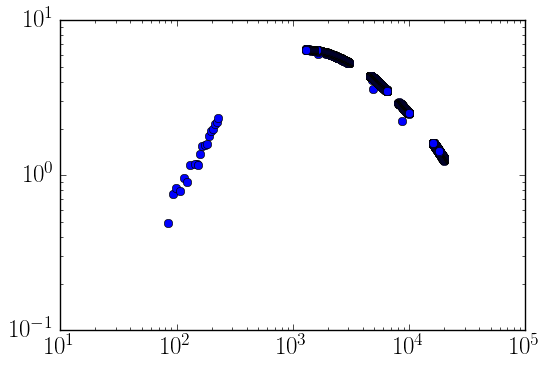

In [18]:
plt.loglog(x,y, 'o')

fitting models: ['curve', 'singSSA', 'doubSSA', 'singinhomobremss', 'singinhomobremssbreak', 'singinhomobremssbreakexp', 'doubhomobremss', 'doubSSAbreakexp']


first guess: [6.5073699999999999, 1308.0, 0.7, -0.3]
Optimization terminated successfully.
         Current function value: -15240.420532
         Iterations: 130
         Function evaluations: 218


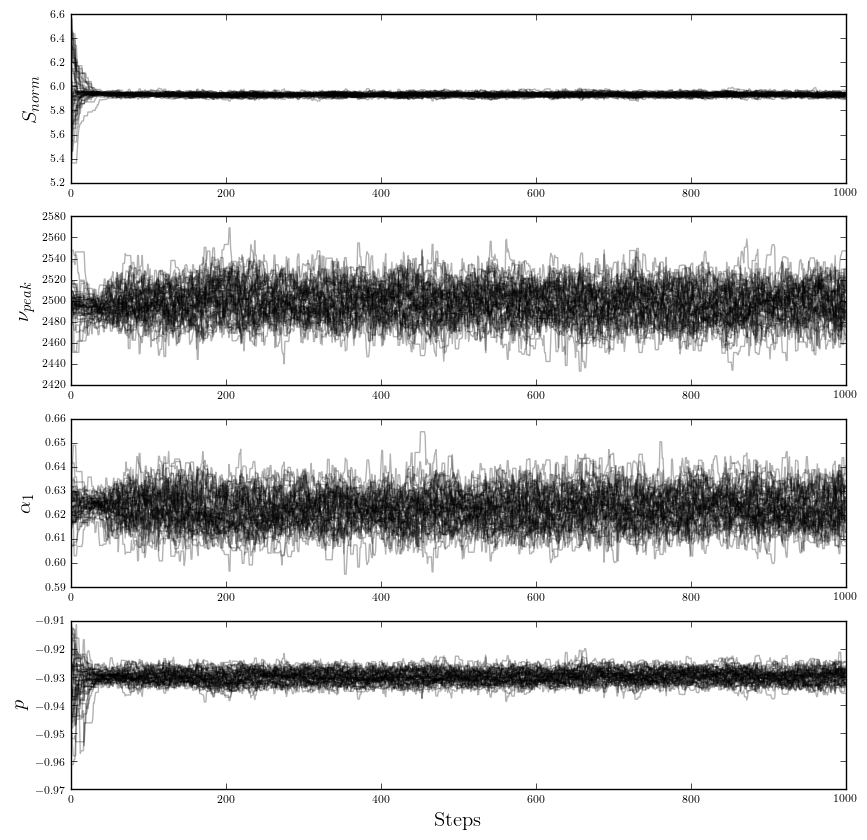

The burnin applied was 500. Make sure the walkers have converged after that many steps.


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [ ]:
interactive = False
model_list = [curve, singSSA, doubSSA, singinhomobremss, singinhomobremssbreak, singinhomobremssbreakexp, doubhomobremss, doubSSAbreakexp]
model_names = [func.__name__ for func in model_list]
print('fitting models: {0}'.format(model_names))
models = pd.DataFrame(index = model_names, columns=['args','leastsquares', 'emcee', 'multinest'])
freq_cont = np.linspace(np.min(x),np.max(y),1000)
for func in model_list:
    print_color("fitting with {0}".format(func.__name__), 'red')
    models.set_value(func.__name__,'args', get_argnames(func))
    ndim = (func.__code__.co_argcount - 1)
    n_params = ndim #oddly, this needs to be specified
    prior_dict = make_prior_dictionary(func, x,y)
    # your guess
    guess = [value.guess for key, value in prior_dict.items()]
    print('first guess: {0}'.format(guess))
    # set least squares fit to be the initial parameter guess for fmin
    leastsquares = pd.DataFrame(data=[[0]], columns=['initial_guess'], index=[0],dtype=object)
    leastsquares['initial_guess'] = [guess]
    
    try:
        popt, pcov = opt.curve_fit(func, x, y, p0 = guess, sigma = yerr)

        redchisq_list = redchisq(y,func(x,*popt),yerr,ndim)

        
        leastsquares['popt'] = [popt]
        leastsquares['pcov'] = [pcov]
        leastsquares['redchisq'] = [redchisq_list]
        
    except:
        leastsquares['popt'] = [[0,0]]
        leastsquares['pcov'] = [[0,0]]
        leastsquares['redchisq'] = [[0,0]]
        
    models.set_value(func.__name__,'leastsquares', leastsquares)
    
    # flip our likelihood function so that when we minimize nll, we are max'ing our likelihood?
    nll = lambda *args: -lnlike(*args)

    # minimize function with downhill simplex algorithm
    # returns array of paramaters that minimizes the input function, value of function at that min, number of iterations, number of function calls
    # warningflag 1 (max func evals reached) or 2 (max iter reached), solution at each iteration
    try:
        result = opt.fmin(nll, popt, args=(ndim,n_params), full_output='true')
    except:
        result = opt.fmin(nll, guess, args=(ndim,n_params), full_output='true')
        
    scale = 1e-3 # noise scale, should be less than 1 
    pos = populate_walkers(ndim, scale, nwalkers, prior_dict, guess=result[0], set_to_random=True)
    # initializing walkers randomly
    #pos = np.random.rand(nwalkers, ndim)

#     print('*lnprior1*', list(map(lambda p: emcee_lnprior(p, prior_dict), pos)))
#     print('*lnlike*', list(map(lambda p: lnlike(p, ndim, n_params), pos)))
#     print('*lnprob*', list(map(lambda p: emcee_lnprob(p, ndim, n_params, prior_dict), pos)))
    

    # for the prior
    sampler = emcee.EnsembleSampler(nwalkers, ndim, emcee_lnprob, args=(ndim, n_params, prior_dict))
    sampler.run_mcmc(pos, nsteps) # This is the workhorse step.

    fig = plt.figure(2,figsize=(10, 10))
    fig.clf()
    for j in range(ndim):
        ax = fig.add_subplot(ndim,1,j+1)
        ax.plot(np.array([sampler.chain[:,i,j] for i in range(nsteps)]),"k", alpha = 0.3)
        ax.set_ylabel((make_plot_labels(func))[j], fontsize = 15)
        ax.tick_params(axis='both', which='major', labelsize=8)
    plt.xlabel('Steps', fontsize = 15)
    display(fig)


    if interactive:
        burnin = int(input('burnin?'))
    fig.clf()


    # To me it looks like the burn in period is well and truly over by n steps. So I will exclude those. 
    print( 'The burnin applied was {0}. Make sure the walkers have converged after that many steps.'.format(burnin))
    samples = sampler.chain[:,burnin:,:].reshape((-1,ndim))
    # Plotting the histograms of the fit.
    trifig = corner.corner(samples, labels = make_plot_labels(func))
    trifig.savefig(image_dir+'/{0}_{1}.png'.format(name,func.__name__))
    plt.close()

    # Finally to get the final uncertainties you do
    uncertainties_mcmc = list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples,[16,50,84], axis = 0)))) # Uncertainites based on the 16th, 50th and 84th percentile.
    emcee_fit = np.asarray([u[0] for u in uncertainties_mcmc])

    flux_arr_store = np.zeros((200,1000))
    lower_flux_arr, upper_flux_arr = np.zeros(1000), np.zeros(1000)

    j=0
    for sample in samples[np.random.randint(len(samples), size=200)]:
        for i in range(1000):
            flux_arr_store[j,i] = func(freq_cont[i], *sample)
            lower_flux_arr[i], upper_flux_arr[i] = np.percentile(flux_arr_store[:,i],[16,84], axis = 0)
        j = j+1

    mc = pd.DataFrame(data=[[0]], columns=['nwalkers'], index=[0], dtype=object)
    mc['nwalkers'] = nwalkers
    mc['nsteps'] = nsteps
    mc['burnin'] = burnin
    mc['rand_seed'] = rand_seed
    mc['uncertainties'] = [uncertainties_mcmc]
    mc['lowerfluxarr'] = [lower_flux_arr]
    mc['upperfluxarr'] = [upper_flux_arr]
    mc['fit'] = [emcee_fit]

    models.set_value(func.__name__,'emcee', mc)



    # multinest
    # number of dimensions our problem has
    ndim = (func.__code__.co_argcount - 1)
    n_params = ndim #oddly, this needs to be specified
    print('emcee fit: {0}'.format(emcee_fit))

    # sigma away from emcee's guess
    sig = 3
    pymultinest.run(lnlike,multinest_lnprior,n_params, resume = False, verbose = True,sampling_efficiency = 0.3)

    # lets analyse the results
    a = pymultinest.Analyzer(n_params = n_params) #retrieves the data that has been written to hard drive
    s = a.get_stats()
    values = s['marginals'] # gets the marginalized posterior probability distributions 
    mn_fit = [values[i]['median'] for i in np.arange(len(values))]
    multinest = pd.DataFrame(data=[[0]], columns=['marginals'], index=[0], dtype=object)
    multinest['fit'] = [mn_fit]
    for key in s:
        if isinstance(s[key], list):
            pass
        else:
            multinest[key] = s[key]

    marginals = pd.DataFrame.from_dict(s['marginals'], dtype=None)
    modes = pd.DataFrame.from_dict(s['modes'], dtype=None)
    multinest.set_value(0,'marginals', marginals)
    multinest.set_value(0,'modes', modes)

    models.set_value(func.__name__,'multinest', multinest)

    print('summary for {0}'.format(func.__name__))
    print(" "*20+'{0}'.format(func.__code__.co_varnames[:func.__code__.co_argcount][1:]))
    print('leastsquares fit:{0}'.format(popt))
    print('emcee fit: {0}'.format(emcee_fit))
    print('multinest fit:{0}'.format(mn_fit))
    print('diff bw emcee and multinest:')
    print(np.subtract(emcee_fit,mn_fit))

models.to_pickle(model_ev_dir + name + '.pkl')

## Evidence Values

In [ ]:
def show_delz(z2, models):
    # Jefferys Scale
    # delz >= 3 is strong evidence that M2 is favored over M1
    # 1 < delz < 3 is moderate evidence
    # 0 < delz < 1 is inconclusive
    # delz = z2 - z1
    z2_ev = models.loc[z2].multinest['nested sampling global log-evidence'].values[0]
    z2_ev_err = models.loc[z2].multinest['nested sampling global log-evidence error'].values[0]
    
    for idx in models.index:
        if z2 == idx:
            continue
        mn_ev = models.loc[idx].multinest['nested sampling global log-evidence'].values[0]
        mn_ev_err = models.loc[idx].multinest['nested sampling global log-evidence error'].values[0]
        del_z = z2_ev - mn_ev
        del_z_err = z2_ev_err - mn_ev_err
        string = '({0} - {1}): {2:.2f} +/- {3:.2f}'.format(z2, idx, del_z, del_z_err)
        
        if del_z >= 3:
            print_color(string + '   *', color='red')
        elif 1 < del_z < 3:
            print_color(string, color='maroon')
        elif 0 < del_z < 1:
            print_color(string, color='black')
        else:
            print_color(string, color='gray')

In [ ]:
# print out evidence
mn_ev_arr = []
for idx in models.index:
    mn_evidence = models.loc[idx].multinest['nested sampling global log-evidence'].values[0]
    mn_evidence_err = models.loc[idx].multinest['nested sampling global log-evidence error'].values[0]
    mn_ev_arr.append(mn_evidence + np.abs(mn_evidence_err))
    print('multinest evidence for {0}: {1:.2f} +/- {2:.2f}'.format(idx,mn_evidence,mn_evidence_err))
best_model = [models.index[x] for x in np.argsort(mn_ev_arr)[::-1]]
print('best to worst models: {0}'.format(best_model))


In [ ]:
# Jefferys Scale
# delz = z2 - z1

print_color('delz >= 3 is strong evidence that M2 is favored over M1', color = 'red')
print_color('1 < delz < 3 is moderate evidence', color = 'maroon')
print_color('0 < delz < 1 is inconclusive', color = 'black')

for idx in models.index:
    show_delz(idx, models)

In [ ]:
# save data frames
sed_df.set_value(source_index, 'best_model', best_model)
sed_df.to_pickle(model_ev_dir+'modeled_df.pkl')

# Latex Table

In [ ]:
latex_dict = {'curve': 'General', 'singSSA': 'Single SSA', 'doubSSA': 'Double SSA', 'singinhomobremss':'Single Inhomogeneous FFA',
              'singinhomobremssbreak':'Single Inhomogeneous FFA + break', 'singinhomobremssbreakexp':'Single Inhomogeneous FFA + exp. break',
              'doubhomobremss':'Double Homogeneous FFA','doubSSAbreakexp':'Double SSA + exp. break'}

In [ ]:
# generate latex table of result
tex_code = r'''
\begin{sidewaystable}
	\renewcommand{\arraystretch}{2}
	\scriptsize
	\centering
	\caption{\label{longtable} Best fit parameters and their associated uncertainties for the different absorption models. }
        \resizebox{\linewidth}{!}{%
	\begin{tabular}{lccccccccccccc}
	\hline
	\hline
Models & $a_{1}$ (Jy) &  $a_{2}$ (Jy) & $\alpha_{1}$ & $\alpha_{2}$ & $\beta_{1}$ & $\beta_{2}$  & $\nu_{\mathrm{p},1}$ (GHz)  & $\nu_{\mathrm{p},2}$ (GHz)  & $p$ & $q$ & $\nu_{\mathrm{br}}$ (GHz) & $\chi^{2}_{\mathrm{red}}$ & $\ln(Z)$ \\
		\hline'''

for idx in models.index.tolist():
    args = list(models.loc[idx].args)
    values = models.loc[idx].multinest['fit'].values[0]
    errs =  models.loc[idx].multinest.marginals.values[0].sigma.values
    print(idx,args, values)
    toprint = '\n {0} & '.format(latex_dict[idx])
    for parameter in ['S_norm','S_norm2', 'alpha', 'alpha2', 'beta', 'beta2', 'peak_freq', 'peak_freq2', 'p', 'q', 'break_freq']:
        if parameter not in args:
            toprint += '$\cdots$ & '
        else:
            toprint += '{0:.2f} '.format(values[args.index(parameter)])
            #find_param_uncertainty(value)
            toprint += '$\pm$ {0:.2f} & '.format(errs[args.index(parameter)])
    # reduced chi
    red_chi = models.loc[idx].leastsquares.redchisq.values[0]
    toprint += '{0:.2f} '.format(red_chi[0])
    toprint += r'$\pm$ {0:.2f} & '.format(red_chi[1])
    
    # lnz
    mn_evidence = models.loc[idx].multinest['nested sampling global log-evidence'].values[0]
    mn_evidence_err = models.loc[idx].multinest['nested sampling global log-evidence error'].values[0]
    toprint += '{0:.2f} '.format(mn_evidence)
    toprint += r'$\pm$ {0:.2f} \\'.format(mn_evidence_err)
    


    tex_code += toprint


tex_code += r'''
        \hline
        \end{tabular}}
\end{sidewaystable}
'''

#{0}  & {1:.2f} $\pm$ {2:.2f} &  {3} &  {4} $\pm$ {5}    & {6}  &  {7} & {8} & {9} $\pm$ {10}   &  {11} & {12} & {13}  & {14} & {15} $\pm${16} \\


# 	 Double Homogeneous FFA & 3.6 $\pm$ 0.2 &  5.8 $\pm$ 0.2 & $-1.27^{+0.05}_{-0.04}$  &  $-1.28$ $\pm$ 0.03 & $\cdots$	& $\cdots$  & 0.293 $\pm$ 0.007  & 0.93 $\pm$ 0.05  & $\cdots$ & $\cdots$ & 5.52 & $-422.4$ $\pm$ 0.2 \\
# 	 Inhomogeneous FFA  & 12.0 $\pm$  0.3 &   $\cdots$ &  $-1.221$ $\pm$ 0.008 & $\cdots$  &$\cdots$ &$\cdots$ & 0.75 $\pm$ 0.02 & $\cdots$ & 0.24 $\pm$ 0.04 & $\cdots$ & 5.72& $-419.0$ $\pm$ 0.6\\
# 	 Internal FFA & 8.8 $\pm$ 0.1 &  $\cdots$ & $-1.240$ $\pm$ 0.008  &  $\cdots$ & $\cdots$& $\cdots$ & 0.90 $\pm$ 0.02 & $\cdots$ & $\cdots$ & $\cdots$ & 7.13 & $-567.4$ $\pm$ 0.2\\
# 	   Single SSA & 13.4 $\pm$ 0.2  & $\cdots$ & $\cdots$ &$\cdots$ & 3.27 $\pm$ 0.01 	& $\cdots$ & 0.575 $\pm$ 0.008  & $\cdots$   & $\cdots$ & $\cdots$ & 13.83& $-609.5$ $\pm$ 0.1 \\
# 	Double SSA & 12.2 $\pm$ 0.3 & 2.5 $\pm$ 0.2 & $\cdots$ & $\cdots$ & 3.48 $\pm$ 0.06 &  3.56$^{+0.08}_{-0.07}$ & 0.459 $\pm$ 0.009  &  1.56 $\pm$ 0.7 & $\cdots$& $\cdots$ &5.36 & $-408.5$ $\pm$ 0.3\\
# 	 Single SSA + exp. break & 12.4 $\pm$  0.2 	& $\cdots$ &$\cdots$ &  $\cdots$ & 2.61 $\pm$ 0.03 & $\cdots$  & 0.75 $\pm$ 0.02  & $\cdots$ & 13.7 $\pm$ 0.7 & $\cdots$ & 2.39 & $-336.6$ $\pm$ 0.2\\
# 	 Double SSA + exp. break & 8.3$^{+0.6}_{-0.7}$ & 6.1$^{+0.7}_{-0.6}$  & $\cdots$  &  $\cdots$ & 3.3$^{+0.3}_{-0.2}$ &  2.55$^{+0.06}_{-0.08}$ & 0.34$^{+0.07}_{-0.08}$   &  0.73$^{+0.04}_{-0.05}$ & $\cdots$ & 12 $\pm$ 2 & 1.09 & $-305.8$ $\pm$ 0.3 \\
# 	 Inhomogeneous FFA + exp. break & 12.9 $\pm$  0.3	& $\cdots$ & $-0.93$ $\pm$ 0.02  & $\cdots$ &$\cdots$ & $\cdots$& 0.55 $\pm$ 0.02  & $\cdots$ & 0.37$^{+0.07}_{-0.06}$ & 19 $\pm$ 1 & 0.80 & $-304.1$ $\pm$ 0.1\\

print(tex_code)

# SED Plot

In [ ]:

# SED plotting
n = 100
plotx, ploty, plotyerr = atca_filter(n, x, y, yerr)
try:
    split = re.split('([0-9]+)',name) 
    plotname = split[0].upper() + " B"+"".join(split[1:])
except:
    pass

model_labels = [latex_dict[model.__name__] for model in model_list]

try:
    print('least squares')
    # least squares fit plot
    fit_list = [models.loc[model.__name__].leastsquares.popt[0] for model in model_list]

    plot = seds_plot_func.sed(model_list,model_labels,fit_list,plotx,
               ploty,plotyerr, plotname, 
               freq_labels = True, savefig = False, resid=True)

    plot.savefig(image_dir+'/{0}_{1}.png'.format(name,'leastsquares'), bbox_inches='tight')
    plt.close()
except:
    pass

print('emcee')
# emcee fit plot
fit_list = [models.loc[model.__name__].emcee.fit[0] for model in model_list]

plot = seds_plot_func.sed(model_list,model_labels,fit_list,plotx,
               ploty,plotyerr, plotname, 
               freq_labels = True, savefig = False, resid=True)

plot.savefig(image_dir+'/{0}_{1}.png'.format(name,'emcee'), bbox_inches='tight')
plt.close()


print('multinest')
# multinest fit plotting
fit_list = [models.loc[model.__name__].multinest.fit[0] for model in model_list]

plot = seds_plot_func.sed(model_list,model_labels,fit_list,plotx,
                   ploty,plotyerr, plotname, 
                   freq_labels = True, savefig = False, resid=True)
plot.savefig(image_dir+'/{0}_{1}.png'.format(name,'multinest'), bbox_inches='tight')
plt.close()

In [ ]:
# print out evidence
mn_ev_arr = []
for idx in models.index:
    mn_evidence = models.loc[idx].multinest['nested sampling global log-evidence'].values[0]
    mn_evidence_err = models.loc[idx].multinest['nested sampling global log-evidence error'].values[0]
    mn_ev_arr.append(mn_evidence + np.abs(mn_evidence_err))
    print('multinest evidence for {0}: {1:.2f} +/- {2:.2f}'.format(idx,mn_evidence,mn_evidence_err))
best_model = [models.index[x] for x in np.argsort(mn_ev_arr)[::-1]]
print('best to worst models: {0}'.format(best_model))

